# Imports

In [1]:
import os
import numpy as np
import pandas as pd
from copy import deepcopy
from typing import List, Tuple, Dict, Callable

import tensorflow as tf
import tensorflow.keras as keras

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from alibi.explainers import CounterfactualRLTabular, CounterfactualRL
from alibi.models.tensorflow import HeAE
from alibi.models.tensorflow import Actor, Critic
from alibi.explainers.cfrl_base import Callback
from alibi.explainers.backends.cfrl_tabular import get_he_preprocessor, get_statistics, \
    get_conditional_vector, apply_category_mapping
import logging
import pkgutil
import tarfile
import json
from io import BytesIO, StringIO
from typing import Optional, Tuple, Union, Dict

import numpy as np
import pandas as pd
import requests
from requests import RequestException
from sklearn.preprocessing import LabelEncoder

from alibi.utils.data import Bunch

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
GERMAN_CREDIT_URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'

def fetch_german_credit(return_X_y: bool = False) -> Union[Bunch, Tuple[np.ndarray, np.ndarray]]:
    """
    Loads and pre-processes the 'german_credit' dataset.
    More info: http://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29

    Parameters
    ----------
    return_X_y : bool, default=False
        If True, return features `X` and labels `y` as numpy arrays.
        If False, return a Bunch object.

    Returns
    -------
    Bunch
        Dataset, labels, a list of features, and a dictionary containing a list with the potential categories
        for each categorical feature where the key refers to the feature column.
    (data, target) : tuple
        Only if return_X_y=True.
    """

    # Load the data from the provided file
    data = pd.read_csv('datasets/german.data', delimiter=' ', header=None)

    # Extract features and labels
    features = data.iloc[:, :-1]
    labels = data.iloc[:, -1].values - 1  # Adjusting the labels to be 0 (Good) and 1 (Bad)
    
    # Categorical columns indices based on dataset description
    categorical_cols = [0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19]
    attribute_mappings = {
    0: {"A11": "<0 DM", "A12": "0-200 DM", "A13": ">=200 DM", "A14": "noaccount"},
    2: {"A30": "no credits", "A31": "all paid", "A32": "paid till", "A33": "late pay", "A34": "critical"},
    3: {"A40": "car(new)", "A41": "car(used)", "A42": "furniture", "A43": "radio/tv", "A44": "appliances", "A45": "repairs", "A46": "education", "A47": "vacation?", "A48": "retrain", "A49": "business", "A410": "others"},
    5: {"A61": "<100 DM", "A62": "100-500DM", "A63": "500-1kDM", "A64": ">=1k DM", "A65": "unknown"},
    6: {"A71": "unemploy", "A72": "<1 year", "A73": "1-3yrs", "A74": "4-6yrs", "A75": ">=7yrs"},
    8: {"A91": "male:div", "A92": "fem:div/mar", "A93": "male:single", "A94": "male:mar", "A95": "fem:single"},
    9: {"A101": "none", "A102": "co-app", "A103": "guarantor"},
    11: {"A121": "realest", "A122": "life ins", "A123": "car", "A124": "unknown"},
    13: {"A141": "bank", "A142": "stores", "A143": "none"},
    14: {"A151": "rent", "A152": "own", "A153": "free"},
    16: {"A171": "unemploy", "A172": "unskilled", "A173": "skilled", "A174": "mgmt/self"},
    18: {"A191": "none", "A192": "yes"},
    19: {"A201": "yes", "A202": "no"}
    }

    # Apply mappings to the data
    for col, mapping in attribute_mappings.items():
        for key, value in mapping.items():
            mask = features.iloc[:, col] == key
            features.iloc[mask, col] = value

    # Map for storing category data
    category_map = {}
    for col in categorical_cols:
        le = LabelEncoder()
        features[col] = le.fit_transform(features[col].values)
        category_map[col] = list(le.classes_)
    # Convert features to numpy array for consistency with the other fetch function
    features = features.values
    
    # Feature and target names
    feature_names = [
        'ExistingChecking', 'Duration', 'CreditHistory', 'Purpose', 'CreditAmount', 'SavingsAccount',
        'EmploymentSince', 'InstallmentRatePercentage', 'PersonalStatusSex', 'OtherDebtors', 'PresentResidenceSince',
        'Property', 'Age', 'OtherInstallmentPlans', 'Housing', 'ExistingCreditsAtBank', 'Job', 
        'PeopleLiableToProvideMaintenance', 'Telephone', 'ForeignWorker'
    ]
    
    
    target_names = ['Good', 'Bad']  # Based on dataset description: 1 = Good, 2 = Bad

    if return_X_y:
        return features, labels

    return Bunch(data=features, target=labels, feature_names=feature_names, target_names=target_names, category_map=category_map)


# Encoding

In [4]:
import tensorflow as tf
from tensorflow import keras
from typing import List

class GermanCreditEncoder(keras.Model):
    """
    German Credit encoder used for Counterfactual with Reinforcement Learning experiments. The model consists of
    two fully connected layers with ReLU and tanh nonlinearities. The tanh nonlinearity clips the embedding in [-1, 1]
    as required in certain algorithms. The layers' dimensions can be set as desired, but for this example, 
    we'll use dimensions similar to the ADULTEncoder.
    """

    def __init__(self, hidden_dim: int, latent_dim: int, **kwargs):
        """
        Constructor.

        Parameters
        ----------
        hidden_dim
            Hidden dimension.
        latent_dim
            Latent dimension.
        """
        super().__init__(**kwargs)
        self.fc1 = keras.layers.Dense(hidden_dim)
        self.fc2 = keras.layers.Dense(latent_dim)

    def call(self, x: tf.Tensor, **kwargs) -> tf.Tensor:
        """
        Forward pass.

        Parameters
        ----------
        x
            Input tensor.
        **kwargs
            Other arguments.

        Returns
        -------
        Encoding representation having each component in the interval [-1, 1].
        """
        x = tf.nn.relu(self.fc1(x))
        x = tf.nn.tanh(self.fc2(x))
        return x

# For the decoder, we'll first need to determine the output dimensions based on the number of unique values 
# for each categorical variable in the german_credit dataset. Let's calculate those dimensions.


In [5]:
# Calculate the output dimensions for the GermanCreditDecoder based on the number of unique values 
# for each categorical variable in the german_credit dataset

german = fetch_german_credit()
# Recall the categorical columns indices for the german_credit dataset
categorical_cols = [0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19]

# Calculate the unique values for each categorical column
output_dims = [len(german.category_map[col]) for col in categorical_cols]

# The first dimension will be for the numerical features. 
# We obtain it by subtracting the number of categorical columns from the total number of columns.
output_dims.insert(0, german.data.shape[1] - len(categorical_cols) - 1)  # -1 to exclude the target column


In [6]:
# Defining the GermanCreditDecoder class

class GermanCreditDecoder(keras.Model):
    """
    German Credit decoder used for Counterfactual with Reinforcement Learning experiments. The model consists of
    a fully connected layer with ReLU nonlinearity, and a multiheaded layer, one for each categorical feature and
    a single head for the rest of numerical features. 
    """

    def __init__(self, hidden_dim: int, output_dims: List[int], **kwargs):
        """
        Constructor.

        Parameters
        ----------
        hidden_dim
            Hidden dimension.
        output_dims
            List of output dimensions, one for each categorical variable and one for all numerical variables combined.
        """
        super().__init__(**kwargs)

        self.fc1 = keras.layers.Dense(hidden_dim)
        self.fcs = [keras.layers.Dense(dim) for dim in output_dims]

    def call(self, x: tf.Tensor, **kwargs) -> List[tf.Tensor]:
        """
        Forward pass.

        Parameters
        ----------
        x
            Input tensor.
        **kwargs
            Other arguments. Not used.

        Returns
        -------
        List of reconstructions of the input tensor. The first element corresponds to the reconstruction 
        of all the numerical features, and the subsequent elements correspond to each categorical feature.
        """
        x = tf.nn.relu(self.fc1(x))
        xs = [fc(x) for fc in self.fcs]
        return xs

# The defined GermanCreditEncoder and GermanCreditDecoder can be used similarly to the provided ADULTEncoder and ADULTDecoder.


In [7]:
# Fetch adult dataset
german = fetch_german_credit()

# Separate columns in numerical and categorical.
categorical_names = [german.feature_names[i] for i in german.category_map.keys()]
categorical_ids = list(german.category_map.keys())

numerical_names = [name for i, name in enumerate(german.feature_names) if i not in german.category_map.keys()]
numerical_ids = [i for i in range(len(german.feature_names)) if i not in german.category_map.keys()]

# Split data into train and test
X, Y = german.data, german.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=13)


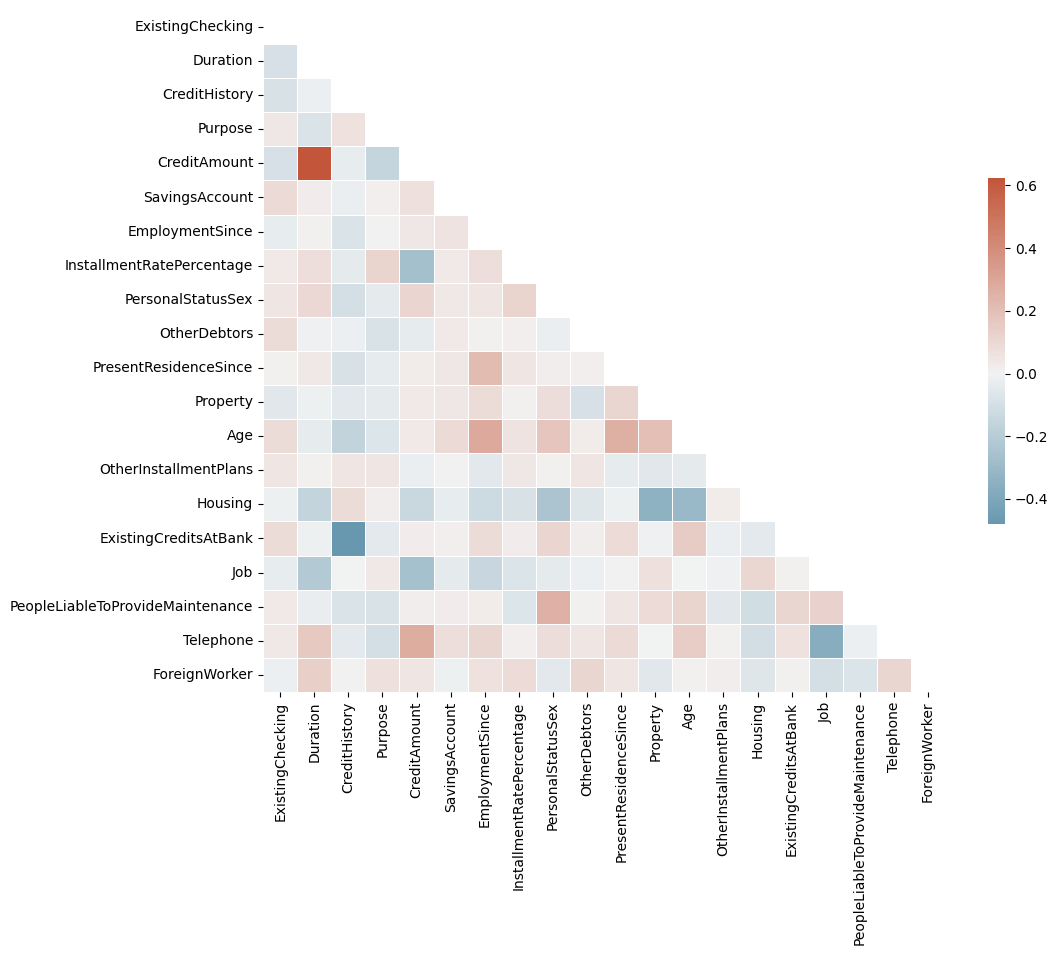

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X is a numpy array, convert it to a DataFrame
df2 = pd.DataFrame(X,columns=german.feature_names)

# Compute the correlation matrix
corr = df2.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


In [9]:
# Define numerical standard scaler.
num_transf = StandardScaler()

# Define categorical one-hot encoder.
cat_transf = OneHotEncoder(
    categories=[range(len(x)) for x in german.category_map.values()],
    handle_unknown="ignore"
)

# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_transf, categorical_ids),
        ("num", num_transf, numerical_ids),
    ],
    sparse_threshold=0
)
# Fit preprocessor.
preprocessor.fit(X_train)

# Preprocess train and test dataset.
X_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

# Select one of the below classifiers.
clf = XGBClassifier(min_child_weight=0.5, max_depth=3, gamma=0.2,random_state = 0)

# Fit the classifier.
clf.fit(X_train_ohe, Y_train)
# Define prediction function.
predictor = lambda x: clf.predict_proba(preprocessor.transform(x))

from sklearn.metrics import classification_report

abc = classification_report(y_true=Y_test, y_pred=predictor(X_test).argmax(axis=1))


print(abc)

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       142
           1       0.52      0.41      0.46        58

    accuracy                           0.72       200
   macro avg       0.65      0.63      0.64       200
weighted avg       0.70      0.72      0.71       200



# SHAP

In [10]:
import numpy as np

predictions = clf.predict(X_test_ohe)
predicted_as_1_indices = np.where(predictions == 1)[0]

# Extracting rows from X_test where the prediction by loaded_model is 1
rows_predicted_as_1 = X_test_ohe[predictions == 1]

# Saving the extracted rows to a .npy file
file_path = "predicted_as_1_german.npy"
np.save(file_path, rows_predicted_as_1)



X_centered = X_test_ohe - X_test_ohe.mean()
distance = np.linalg.norm(X_centered, axis=1)


In [11]:
import pickle

model_path = "xgboost_model_german.pkl"
pickle.dump(clf, open(model_path, 'wb'))

with open('xgboost_model_german.pkl', 'rb') as file:
    loaded_model = pickle.load(file)




In [12]:
import shap
explainer = shap.Explainer(loaded_model)

In [13]:
distances_predicted_as_1 = distance[predicted_as_1_indices]
outlier_indices_predicted_as_1 = distances_predicted_as_1.argsort()[-5:]
final_outlier_indices = predicted_as_1_indices[outlier_indices_predicted_as_1]
outliers_predicted_as_1 = X_test_ohe[final_outlier_indices]
final_outlier_indices

array([110,  42,   0,  96,  70])

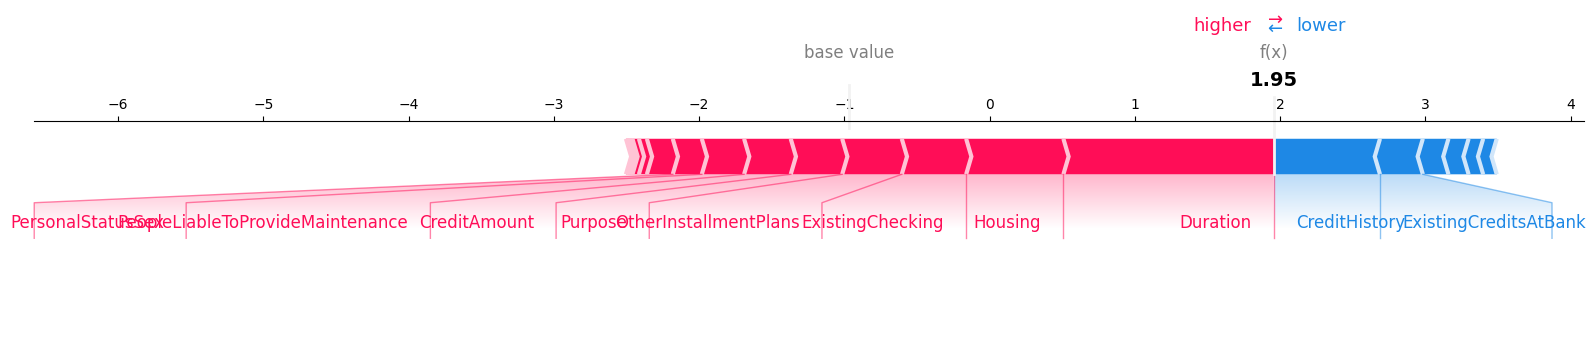

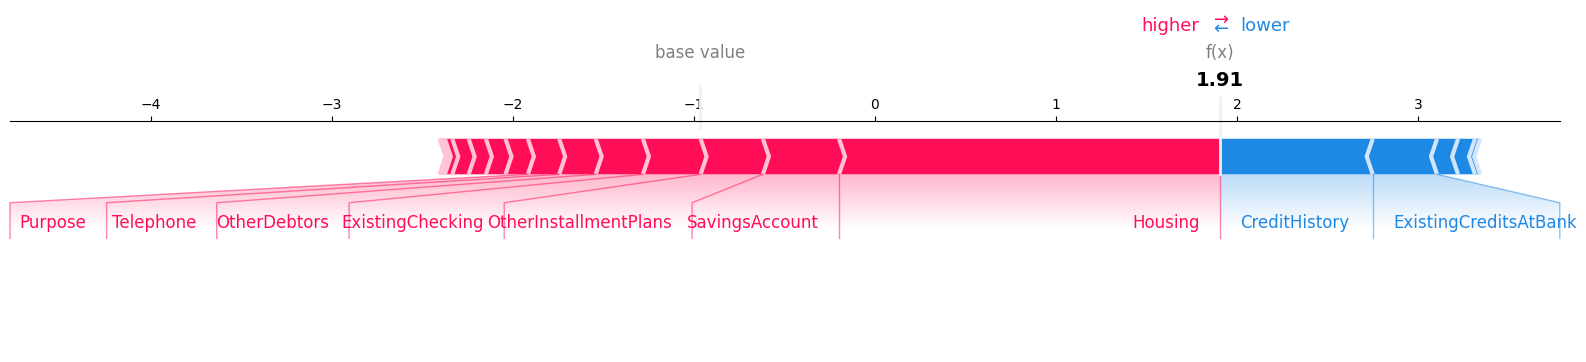

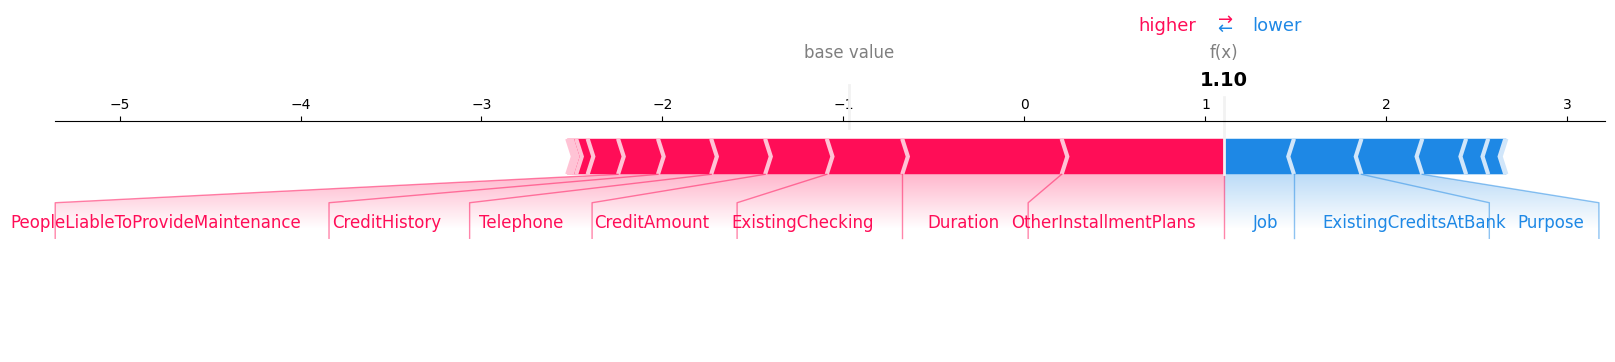

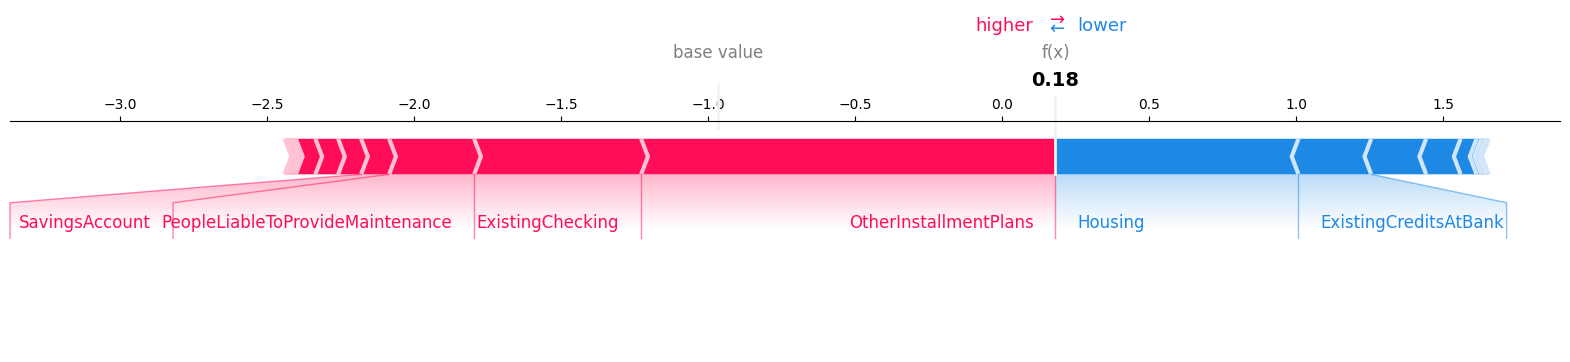

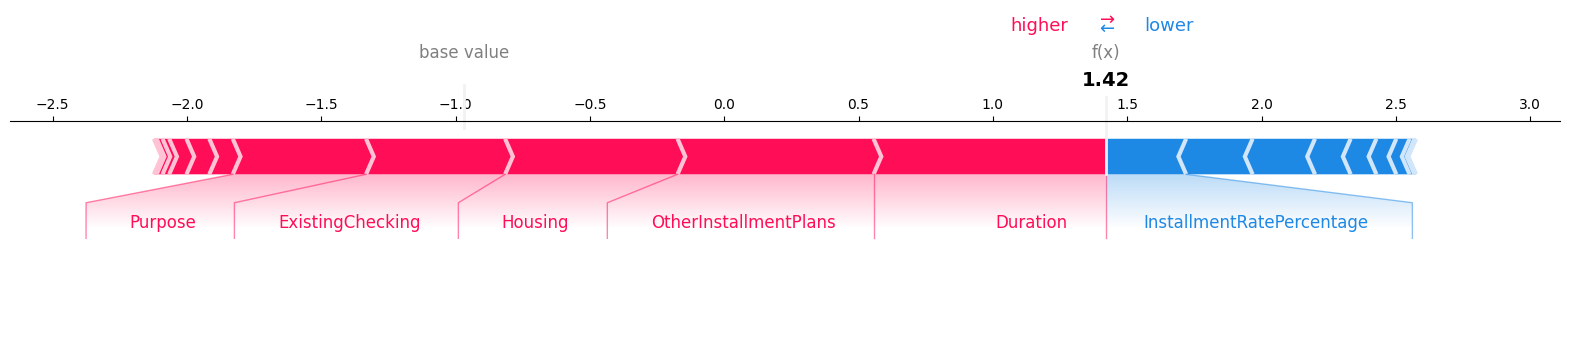

In [15]:
ohe_feature_names = preprocessor.named_transformers_["cat"].get_feature_names_out(input_features=categorical_names)

# 所有特征名称
all_feature_names = list(ohe_feature_names) + numerical_names

def merge_shap_for_ohe(shap_values, categorical_names, ohe_feature_names):
    """
    Merge SHAP values for one-hot encoded features.
    """
    merged_shap_values = []
    start_idx = 0
    for cat_name in categorical_names:
        # Find the number of columns this categorical feature has been expanded into
        ohe_cols = [name for name in ohe_feature_names if cat_name in name]
        num_ohe_cols = len(ohe_cols)
        
        # Sum the SHAP values for these columns
        summed_shap = np.sum(shap_values[:, start_idx:start_idx+num_ohe_cols], axis=1)
        merged_shap_values.append(summed_shap)
        
        start_idx += num_ohe_cols
    
    # Add SHAP values for numerical features
    for i in range(start_idx, shap_values.shape[1]):
        merged_shap_values.append(shap_values[:, i])
    
    return np.column_stack(merged_shap_values)



# 计算outliers_predicted_as_1的SHAP值
shap_values_outliers = explainer.shap_values(outliers_predicted_as_1)

# 合并one-hot编码的SHAP值
merged_shap_values_outliers = merge_shap_for_ohe(shap_values_outliers, categorical_names, ohe_feature_names)

# 为每个样本生成force_plot
for i in range(outliers_predicted_as_1.shape[0]):
    shap.force_plot(
        explainer.expected_value, 
        merged_shap_values_outliers[i], 
        feature_names=german.feature_names,
        matplotlib=True
    )




In [16]:
centered_indices_predicted_as_1 = distances_predicted_as_1.argsort()[:5]
final_centered_indices = predicted_as_1_indices[centered_indices_predicted_as_1]
centered_values_predicted_as_1 = X_test_ohe[final_centered_indices]
final_centered_indices

array([ 10,  43, 132,  44, 192])

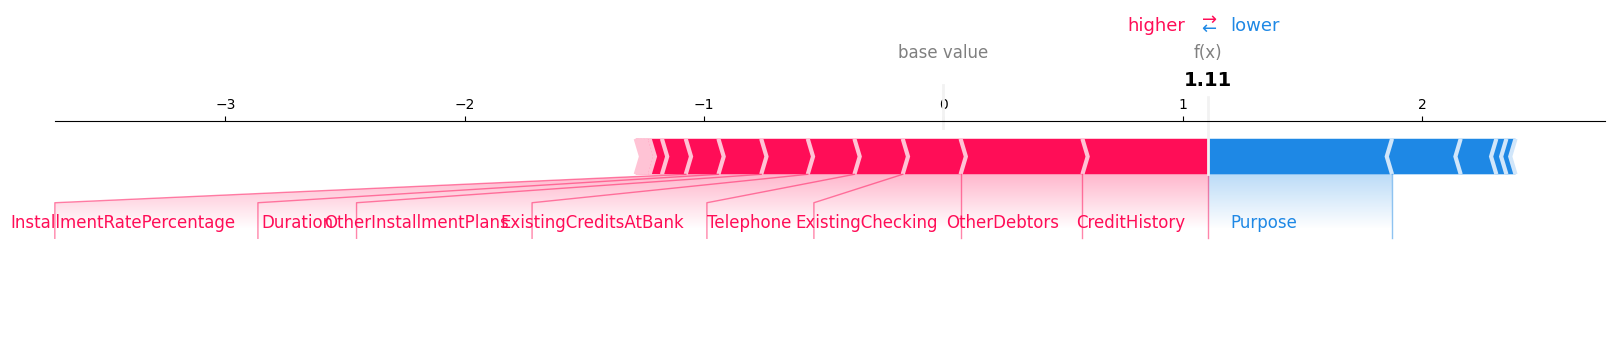

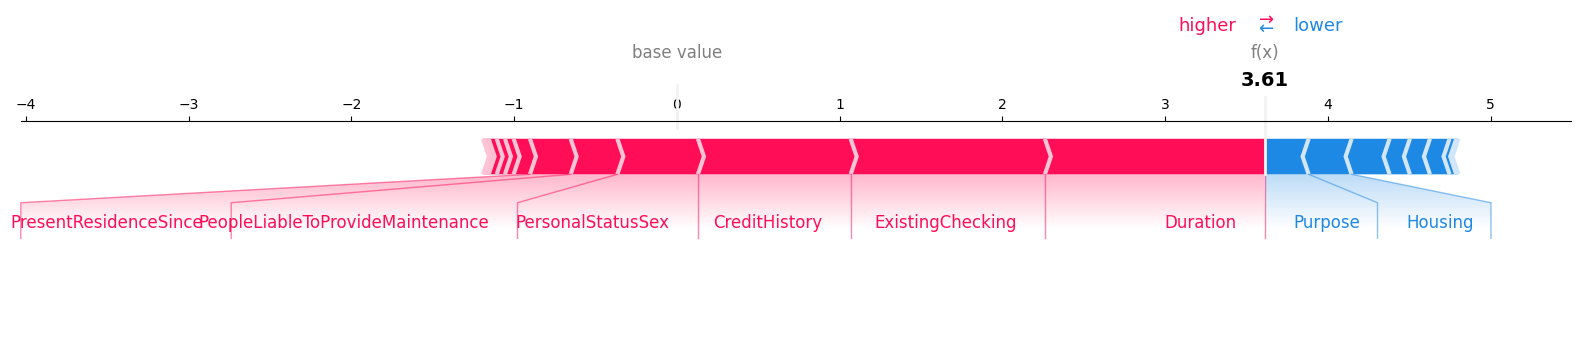

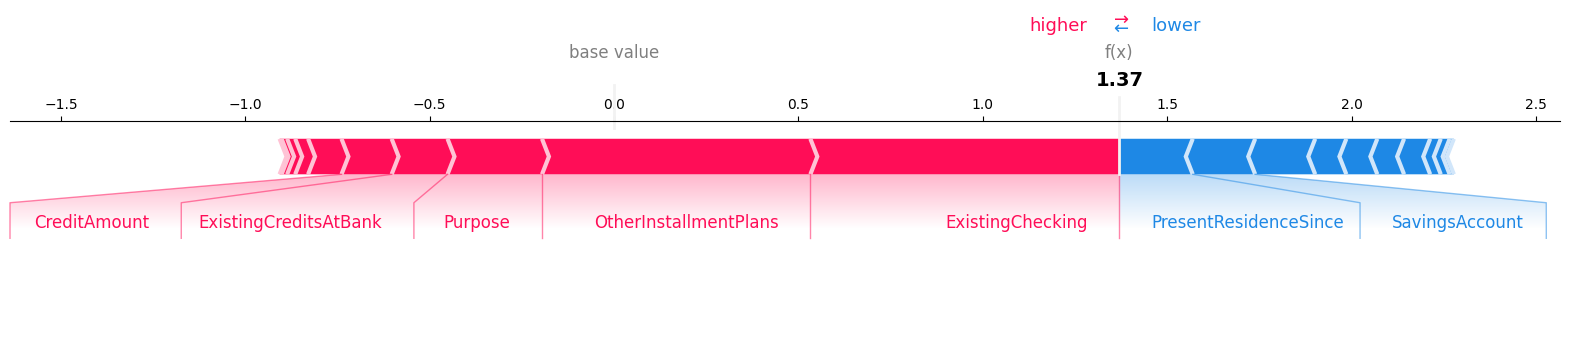

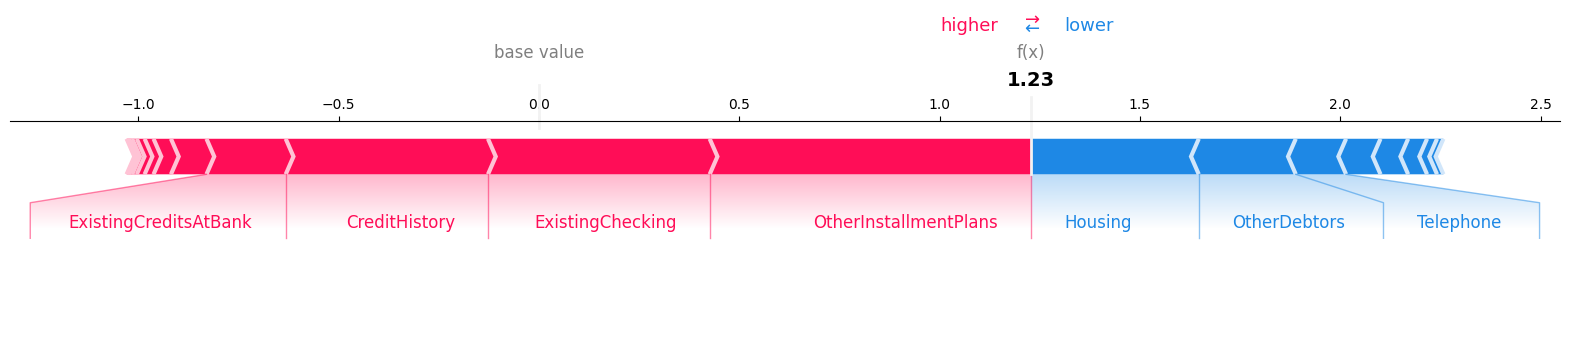

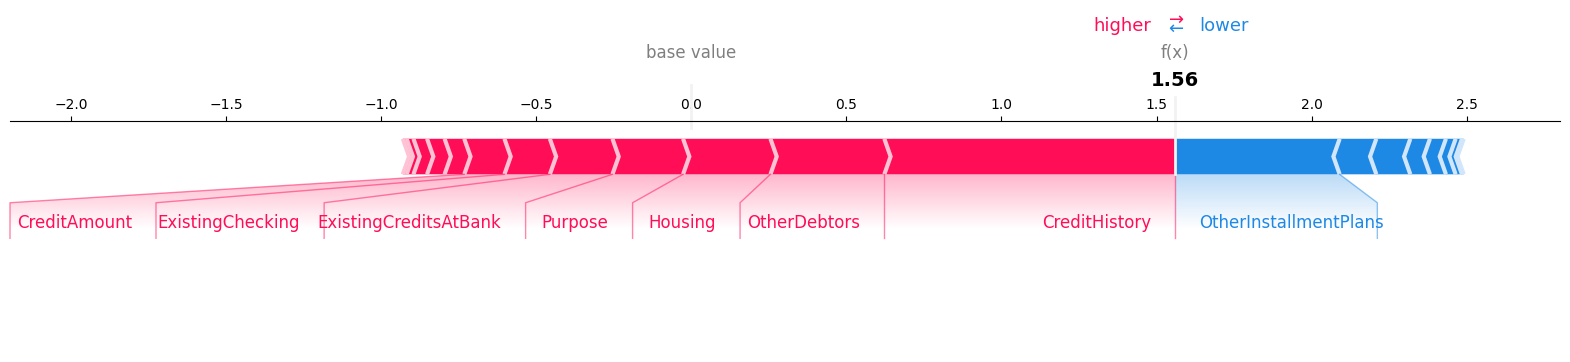

In [18]:
# 计算outliers_predicted_as_1的SHAP值
shap_values_centres = shap.Explainer(loaded_model).shap_values(centered_values_predicted_as_1)

# 合并one-hot编码的SHAP值
merged_shap_values_centres = merge_shap_for_ohe(shap_values_centres, categorical_names, ohe_feature_names)

# 为每个样本生成force_plot
for i in range(outliers_predicted_as_1.shape[0]):
    shap.force_plot(
        shap.Explainer(loaded_model).expected_value, 
        merged_shap_values_centres[i], 
        feature_names=german.feature_names,
        matplotlib=True
    )




In [19]:
# Define attribute types, required for datatype conversion.
feature_types = {
    "Duration": int,
     "CreditAmount": int,
    "InstallmentRatePercentage": int,
     "PresentResidenceSince": int,
    "Age": int,
     "ExistingCreditsAtBank": int,
    "PeopleLiableToProvideMaintenance": int
}


# Define data preprocessor and inverse preprocessor. The invers preprocessor include datatype conversions.
heae_preprocessor, heae_inv_preprocessor = get_he_preprocessor(X=X_train,
                                                               feature_names=german.feature_names,
                                                               category_map=german.category_map,
                                                               feature_types=feature_types)

# Define trainset
trainset_input = heae_preprocessor(X_train).astype(np.float32)
trainset_outputs = {
    "output_1": trainset_input[:, :len(numerical_ids)]
}

for i, cat_id in enumerate(categorical_ids):
    trainset_outputs.update({
        f"output_{i+2}": X_train[:, cat_id]
    })
    
trainset = tf.data.Dataset.from_tensor_slices((trainset_input, trainset_outputs))
trainset = trainset.shuffle(1024).batch(128, drop_remainder=True)

2023-08-31 13:05:53.836473: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 13:05:54.361521: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:82:00.0, compute capability: 8.9


In [20]:
# Define autoencoder path and create dir if it doesn't exist.
heae_path = os.path.join("tensorflow", "German_autoencoder")
if not os.path.exists(heae_path):
    os.makedirs(heae_path)

# Define constants.
EPOCHS = 50              # epochs to train the autoencoder
HIDDEN_DIM = 128         # hidden dimension of the autoencoder
LATENT_DIM = 15          # define latent dimension

# Define output dimensions.
OUTPUT_DIMS = [len(numerical_ids)]
OUTPUT_DIMS += [len(german.category_map[cat_id]) for cat_id in categorical_ids]

# Define the heterogeneous auto-encoder.
heae = HeAE(encoder=GermanCreditEncoder(hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM),
            decoder=GermanCreditDecoder(hidden_dim=HIDDEN_DIM, output_dims=OUTPUT_DIMS))

# Define loss functions.
he_loss = [keras.losses.MeanSquaredError()]
he_loss_weights = [1.]

# Add categorical losses.
for i in range(len(categorical_names)):
    he_loss.append(keras.losses.SparseCategoricalCrossentropy(from_logits=True))
    he_loss_weights.append(1./len(categorical_names))

# Define metrics.
metrics = {}
for i, cat_name in enumerate(categorical_names):
    metrics.update({f"output_{i+2}": keras.metrics.SparseCategoricalAccuracy()})
    
# Compile model.
heae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
             loss=he_loss,
             loss_weights=he_loss_weights,
             metrics=metrics)

if len(os.listdir(heae_path)) == 0:
    # Fit and save autoencoder.
    heae.fit(trainset, epochs=EPOCHS)
    heae.save(heae_path, save_format="tf")
else:
    # Load the model.
    heae = keras.models.load_model(heae_path, compile=False)

In [21]:
# Define constants
COEFF_SPARSITY = 0.5               # sparisty coefficient
COEFF_CONSISTENCY = 0.5            # consisteny coefficient
TRAIN_STEPS = 20000                # number of training steps -> consider increasing the number of steps
BATCH_SIZE = 100                   # batch size

In [22]:
continuous_features = ['Duration', 'CreditAmount', 'InstallmentRatePercentage', 'PresentResidenceSince', 'Age', 'ExistingCreditsAtBank', 'PeopleLiableToProvideMaintenance']
immutable_features = ['PersonalStatusSex', 'PeopleLiableToProvideMaintenance', 'ForeignWorker', 'Purpose']
non_decreasing_features = ['Age', 'PresentResidenceSince']
correlated_features = []

# Define ranges. This means that the `Age` feature can not decrease.
ranges = {
    'Duration': [-1.0, 1.0],  # 自由特征
    'CreditAmount': [-1.0, 1.0],  # 自由特征
    'InstallmentRatePercentage': [-1.0, 1.0],  # 自由特征
    'PresentResidenceSince': [0.0, 1.0],  # 只能增加
    'Age': [0.0, 1.0],  # 只能增加
    'ExistingCreditsAtBank': [-1.0, 1.0],  # 自由特征
    'PeopleLiableToProvideMaintenance': [-1.0, 1.0]  # 自由特征
}


In [23]:
from sklearn.neighbors import NearestNeighbors


def find_proximity_cont(cfe, original_datapoint, continuous_features, mads):
    diff = original_datapoint[continuous_features].to_numpy() - cfe[continuous_features].to_numpy()
    
    changed_features_count = np.sum(diff != 0)
   
    avg_changed_features = changed_features_count / len(continuous_features)
    
    avg_dist_cont = np.mean(np.divide(np.abs(diff), mads))
    return avg_dist_cont, avg_changed_features


def find_proximity_cat(cfe, original_datapoint, encoded_columns):
    """
    cfe: Counterfactual example after one-hot encoding.
    original_datapoint: Original data point after one-hot encoding.
    encoded_columns: List of columns after one-hot encoding.
    """
    
    diff = original_datapoint[encoded_columns].to_numpy() - cfe[encoded_columns].to_numpy()
    
    
    original_features = set([col.split("_")[0] for col in encoded_columns])
    
    
    changed_features = set()
    for feature in original_features:
        encoded_feature_cols = [col for col in encoded_columns if col.startswith(feature + "_")]
        if np.any(diff[0][[encoded_columns.index(col) for col in encoded_feature_cols]] != 0):
            changed_features.add(feature)
    
    sparsity_cat = len(changed_features)

    total_original_features = len(original_features)
    dist_cat = sparsity_cat * 1.0 / total_original_features
    return dist_cat, sparsity_cat



def get_encoded_columns(original_column, cfe_columns):
    """Get the OneHotEncoded column names for a given original column."""
    return [col for col in cfe_columns if col.startswith(original_column + "_")]

def follows_causality(cfe, original_datapoint, immutable_features, 
        non_decreasing_features, correlated_features):
    follows = True
    diff = cfe.to_numpy().astype(float) - original_datapoint.to_numpy()
    m2 = (diff != 0)[0].nonzero()
    changed_columns = cfe.columns[m2].tolist()
    
    # Convert immutable features to their encoded names
    immutable_features_encoded = []
    for feature in immutable_features:
        immutable_features_encoded.extend(get_encoded_columns(feature, cfe.columns))
    
    # Check immutable features
    changed_immutable_features = set(changed_columns).intersection(set(immutable_features_encoded))
    if changed_immutable_features:

            follows = False
            return follows

    # Convert non-decreasing features to their encoded names
    non_decreasing_features_encoded = []
    for feature in non_decreasing_features:
        non_decreasing_features_encoded.extend(get_encoded_columns(feature, cfe.columns))
    
    # Check non-decreasing features
    diff_nondecrease = cfe[non_decreasing_features_encoded].to_numpy().astype(float) - original_datapoint[non_decreasing_features_encoded].to_numpy()
    m2 = (diff_nondecrease < 0)[0].nonzero()
    if m2[0].shape[0] > 0:
        follows = False
        return follows
    
    # Check correlated features
    for f1, f2 in correlated_features:
        f1_encoded = get_encoded_columns(f1, cfe.columns)
        f2_encoded = get_encoded_columns(f2, cfe.columns)
        for col1 in f1_encoded:
            seq_f1 = cfe.columns.tolist().index(col1)
            for col2 in f2_encoded:
                seq_f2 = cfe.columns.tolist().index(col2)
                if (diff[0][seq_f1] > 0 and diff[0][seq_f2] <= 0) or (diff[0][seq_f1] < 0 and diff[0][seq_f2] >= 0):
                    follows = False
                    return follows
    
    return follows



def find_manifold_dist(cfe, knn):
    nearest_dist, nearest_points = knn.kneighbors(cfe.to_numpy(), 1, return_distance=True)
    quantity = np.mean(nearest_dist)		# Now we have that lambda, so no need to divide by self.no_points 
    return quantity

def calculate_metrics(counterfactuals_list, dataset, continuous_features, 
                      immutable_features, non_decreasing_features, 
                      correlated_features, scaler, method):
    
    encoder = scaler.named_transformers_['cat']
    categorical_features = dataset.columns[categorical_ids].tolist()
    encoded_columns = encoder.get_feature_names_out(input_features=categorical_features).tolist()
    
    all_transformed_columns = continuous_features + encoded_columns
    
    # 1. Transform the dataset
    transformed_dataset = scaler.transform(dataset.drop(columns=['Outcome']))
    transformed_dataset = pd.DataFrame(transformed_dataset, columns=all_transformed_columns)
    
    # 2. Calculate normalized MADS for continuous features
    normalized_mads = {}
    for feature in continuous_features:
        normalized_mads[feature] = np.median(abs(transformed_dataset[feature].values - np.median(transformed_dataset[feature].values)))
    mads = [normalized_mads[key] if normalized_mads[key] != 0.0 else 1.0 for key in normalized_mads]
    
    # 3. Setup KNN for manifold distance
    knn = NearestNeighbors(n_neighbors=5, p=1)
    knn.fit(transformed_dataset)
    
    # 4. Loop through counterfactuals to calculate metrics
    avg_proximity_cont = []
    avg_proximity_cat = []
    avg_sparsity = []
    avg_causality = []
    avg_manifold_dist = []
    
    
    for instance_series, cf_df in counterfactuals_list:
        instance_df = pd.DataFrame(instance_series)
    
        if method == 'cfrl':
            instance_df = instance_df.iloc[:, :-1]
            cf_df = cf_df.iloc[:, :-1]
    
        elif method == 'kdtree':
            instance_df = instance_df.T
    
        elif method in ['random', 'genetic']:
            instance_df = instance_df.T
            cf_df = cf_df.iloc[:, :-1]
        
        # Transform data
        cfe = cf_df 
        cfe_transformed = scaler.transform(cf_df)
        instance_df_transformed = scaler.transform(instance_df)
        cfe_transformed = pd.DataFrame(cfe_transformed, columns=all_transformed_columns)
        instance_df_transformed = pd.DataFrame(instance_df_transformed, columns=all_transformed_columns)

        

        # Proximity
        proximity_cont, sparsity_cont = find_proximity_cont(cfe_transformed, instance_df_transformed, continuous_features, mads)
        proximity_cat, sparsity_cat = find_proximity_cat(cfe_transformed, instance_df_transformed, encoded_columns)
        
        # Sparsity
        sparsity = sparsity_cont + sparsity_cat
        
        # Causality
        causality = follows_causality(cfe_transformed, instance_df_transformed, immutable_features, 
                                      non_decreasing_features, correlated_features)
        
        # Manifold Distance
        manifold_dist = find_manifold_dist(cfe_transformed, knn)
        
        avg_proximity_cont.append(proximity_cont)
        avg_proximity_cat.append(proximity_cat)
        avg_sparsity.append(sparsity)
        avg_causality.append(causality)
        avg_manifold_dist.append(manifold_dist)
    
    # 5. Calculate average metrics
    avg_metrics = {
        "avg_proximity_cont": np.mean(avg_proximity_cont),
        "avg_proximity_cat": np.mean(avg_proximity_cat),
        "avg_sparsity": np.mean(avg_sparsity),
        "avg_causality": np.mean(avg_causality),
        "avg_manifold_dist": np.mean(avg_manifold_dist)
    }
    
    return avg_metrics


In [24]:
explainer = CounterfactualRLTabular(predictor=predictor,
                                    encoder=heae.encoder,
                                    decoder=heae.decoder,
                                    latent_dim=LATENT_DIM,
                                    encoder_preprocessor=heae_preprocessor,
                                    decoder_inv_preprocessor=heae_inv_preprocessor,
                                    coeff_sparsity=COEFF_SPARSITY,
                                    coeff_consistency=COEFF_CONSISTENCY,
                                    category_map=german.category_map,
                                    feature_names=german.feature_names,
                                    ranges=ranges,
                                    immutable_features=immutable_features,
                                    train_steps=TRAIN_STEPS,
                                    batch_size=BATCH_SIZE,
                                    backend="tensorflow")

In [25]:
explainer = explainer.fit(X=X_train)

  0%|          | 0/20000 [00:00<?, ?it/s]2023-08-31 13:06:09.289338: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-31 13:06:09.455250: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
100%|██████████| 20000/20000 [10:45<00:00, 30.98it/s]


In [26]:
# Select some positive examples.
X_positive = X_test[np.argmax(predictor(X_test), axis=1) == 1]
X_negative = X_test[np.argmax(predictor(X_test), axis=1) == 0]
# Define new feature names and category map by including the label.
feature_names = german.feature_names + ["Label"]
category_map = deepcopy(german.category_map)
category_map.update({feature_names.index("Label"): german.target_names})

In [27]:
X = X_positive[:1000]
Y_t = np.array([0])
C = []
# Generate counterfactual instances.
explanation = explainer.explain(X, Y_t, C)

100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


In [28]:
trained_num_transf = preprocessor.named_transformers_["num"]
# Combine data and target into a single dataframe
df = pd.DataFrame(german.data, columns=german.feature_names)
df['Outcome'] = german.target

In [29]:
# Generate counterfactual instances.
X = X_test[110].reshape(1, -1)
explanation = explainer.explain(X=X, Y_t=Y_t, C=C, diversity=True, num_samples=5, batch_size=10)

# Concat label column.
orig = np.concatenate(
    [explanation.data['orig']['X'], explanation.data['orig']['class']],
    axis=1
)

cf = np.concatenate(
    [explanation.data['cf']['X'], explanation.data['cf']['class']],
    axis=1
)

# Transfrom label encodings to string.
orig_pd = pd.DataFrame(
    apply_category_mapping(orig, category_map),
    columns=feature_names,
)

cf_pd = pd.DataFrame(
    apply_category_mapping(cf, category_map),
    columns=feature_names,
)

merged_df = pd.concat([orig_pd, cf_pd.head()])
print(merged_df)
merged_df.to_csv("g_cfrl_o.csv")

counterfactuals_list_cfrl = []
counterfactuals_list_cfrl.append((orig_pd, cf_pd))


metrics_cfrl = calculate_metrics(counterfactuals_list_cfrl, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='cfrl')
print(metrics_cfrl)

1it [00:00,  7.85it/s]


  ExistingChecking Duration CreditHistory    Purpose CreditAmount  \
0         0-200 DM       42      all paid  car(used)         9283   
0         0-200 DM       28      all paid  car(used)         7729   
1         0-200 DM       28      all paid  car(used)         7876   
2         0-200 DM       28      all paid  car(used)         8556   
3         0-200 DM       28      late pay  car(used)         7941   
4         0-200 DM       29      late pay  car(used)         8534   

  SavingsAccount EmploymentSince InstallmentRatePercentage PersonalStatusSex  \
0        <100 DM        unemploy                         1       male:single   
0      100-500DM          4-6yrs                         2       male:single   
1      100-500DM          4-6yrs                         2       male:single   
2       500-1kDM          4-6yrs                         2       male:single   
3      100-500DM          4-6yrs                         2       male:single   
4      100-500DM          4-6yrs    

In [30]:
# Generate counterfactual instances.
X = X_test[10].reshape(1, -1)
explanation = explainer.explain(X=X, Y_t=Y_t, C=C, diversity=True, num_samples=5, batch_size=10)

# Concat label column.
orig = np.concatenate(
    [explanation.data['orig']['X'], explanation.data['orig']['class']],
    axis=1
)

cf = np.concatenate(
    [explanation.data['cf']['X'], explanation.data['cf']['class']],
    axis=1
)

# Transfrom label encodings to string.
orig_pd = pd.DataFrame(
    apply_category_mapping(orig, category_map),
    columns=feature_names,
)

cf_pd = pd.DataFrame(
    apply_category_mapping(cf, category_map),
    columns=feature_names,
)

merged_df = pd.concat([orig_pd, cf_pd.head()])
merged_df.to_csv("g_cfrl_c.csv")

counterfactuals_list_cfrl = []
counterfactuals_list_cfrl.append((orig_pd, cf_pd))


metrics_cfrl = calculate_metrics(counterfactuals_list_cfrl, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='cfrl')
print(metrics_cfrl)


1it [00:00, 27.17it/s]

{'avg_proximity_cont': 0.0, 'avg_proximity_cat': 0.23076923076923078, 'avg_sparsity': 3.0, 'avg_causality': 0.0, 'avg_manifold_dist': 13.764738564094836}


## Predicted as 1

In [31]:
import time

counterfactuals_list_cfrl = []
time_list = []
validity_list = []

# Assuming X_positive, Y_t, C, category_map, feature_names are already defined
for i in range(X_positive.shape[0]):
    X = X_positive[i].reshape(1, -1)
    
    # 开始计时
    start_time = time.time()
    
    explanation = explainer.explain(X=X, Y_t=Y_t, C=C, diversity=True, num_samples=5, batch_size=10)
    
    
    time_taken = time.time() - start_time
    time_list.append(time_taken)
    
    # Concat label column.
    orig = np.concatenate(
        [explanation.data['orig']['X'], explanation.data['orig']['class']],
        axis=1
    )

    cf = np.concatenate(
        [explanation.data['cf']['X'], explanation.data['cf']['class']],
        axis=1
    )

    # Transform label encodings to string.
    orig_pd = pd.DataFrame(
        apply_category_mapping(orig, category_map),
        columns=feature_names,
    )

    cf_pd = pd.DataFrame(
        apply_category_mapping(cf, category_map),
        columns=feature_names,
    )
    
    # Check validity
    if orig_pd['Label'].iloc[0] != cf_pd['Label'].iloc[0]:
        validity_list.append(1)
    else:
        validity_list.append(0)
    
    counterfactuals_list_cfrl.append((orig_pd, cf_pd))

# Calculate average time and validity
avg_time = np.mean(time_list)
avg_validity = np.mean(validity_list)

print("Average Time Taken per instance:", avg_time)
print("Average Validity:", avg_validity)


1it [00:00, 27.73it/s]
1it [00:00, 36.26it/s]
1it [00:00, 35.83it/s]
1it [00:00, 35.57it/s]
1it [00:00, 35.70it/s]
1it [00:00, 36.13it/s]
1it [00:00, 34.86it/s]
1it [00:00, 36.87it/s]
1it [00:00, 36.44it/s]
1it [00:00, 36.94it/s]
1it [00:00, 36.80it/s]
1it [00:00, 36.55it/s]
1it [00:00, 37.07it/s]
1it [00:00, 37.09it/s]
1it [00:00, 37.12it/s]
1it [00:00, 36.82it/s]
1it [00:00, 37.15it/s]
1it [00:00, 35.26it/s]
1it [00:00, 33.82it/s]
1it [00:00, 37.16it/s]
1it [00:00, 36.92it/s]
1it [00:00, 36.32it/s]
1it [00:00, 36.83it/s]
1it [00:00, 36.65it/s]
1it [00:00, 35.54it/s]
1it [00:00, 36.47it/s]
1it [00:00, 38.27it/s]
1it [00:00, 37.22it/s]
1it [00:00, 36.81it/s]
1it [00:00, 35.57it/s]
1it [00:00, 36.92it/s]
1it [00:00, 37.91it/s]
1it [00:00, 37.17it/s]
1it [00:00, 37.45it/s]
1it [00:00, 34.78it/s]
1it [00:00, 35.30it/s]
1it [00:00, 36.74it/s]
1it [00:00, 35.06it/s]
1it [00:00, 34.89it/s]
1it [00:00, 38.28it/s]
1it [00:00, 36.31it/s]
1it [00:00, 37.21it/s]
1it [00:00, 39.59it/s]
1it [00:00,

Average Time Taken per instance: 0.035515546798706055
Average Validity: 1.0


In [32]:
trained_num_transf = preprocessor.named_transformers_["num"]
# Combine data and target into a single dataframe
df = pd.DataFrame(german.data, columns=german.feature_names)
df['Outcome'] = german.target
metrics = calculate_metrics(counterfactuals_list_cfrl, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='cfrl')
print(metrics)

{'avg_proximity_cont': 0.0, 'avg_proximity_cat': 0.15886287625418066, 'avg_sparsity': 2.0652173913043477, 'avg_causality': 0.8260869565217391, 'avg_manifold_dist': 13.753631878905132}


## Predicted as 0

In [33]:
import time

counterfactuals_list_cfrl = []
time_list = []
validity_list = []

# Assuming X_positive, Y_t, C, category_map, feature_names are already defined
for i in range(X_negative.shape[0]):
    X = X_negative[i].reshape(1, -1)
    
    start_time = time.time()
    
    explanation = explainer.explain(X=X, Y_t=np.array([1]), C=C, diversity=True, num_samples=5, batch_size=10)
    

    time_taken = time.time() - start_time
    time_list.append(time_taken)
    
    # Concat label column.
    orig = np.concatenate(
        [explanation.data['orig']['X'], explanation.data['orig']['class']],
        axis=1
    )

    cf = np.concatenate(
        [explanation.data['cf']['X'], explanation.data['cf']['class']],
        axis=1
    )

    # Transform label encodings to string.
    orig_pd = pd.DataFrame(
        apply_category_mapping(orig, category_map),
        columns=feature_names,
    )

    cf_pd = pd.DataFrame(
        apply_category_mapping(cf, category_map),
        columns=feature_names,
    )
    
    # Check validity
    if orig_pd['Label'].iloc[0] != cf_pd['Label'].iloc[0]:
        validity_list.append(1)
    else:
        validity_list.append(0)
    
    counterfactuals_list_cfrl.append((orig_pd, cf_pd))

# Calculate average time and validity
avg_time = np.mean(time_list)
avg_validity = np.mean(validity_list)

print("Average Time Taken per instance:", avg_time)
print("Average Validity:", avg_validity)


1it [00:00, 38.09it/s]
1it [00:00, 40.31it/s]
1it [00:00, 40.18it/s]
1it [00:00, 38.30it/s]
1it [00:00, 37.78it/s]
1it [00:00, 35.80it/s]
1it [00:00, 38.69it/s]
1it [00:00, 44.71it/s]
1it [00:00, 41.00it/s]
1it [00:00, 40.50it/s]
1it [00:00, 39.28it/s]
1it [00:00, 38.04it/s]
1it [00:00, 38.71it/s]
1it [00:00, 38.15it/s]
1it [00:00, 38.91it/s]
1it [00:00, 37.14it/s]
1it [00:00, 38.54it/s]
1it [00:00, 38.72it/s]
1it [00:00, 38.14it/s]
1it [00:00, 37.89it/s]
1it [00:00, 37.95it/s]
1it [00:00, 39.59it/s]
1it [00:00, 39.01it/s]
1it [00:00, 36.74it/s]
1it [00:00, 37.71it/s]
1it [00:00, 38.08it/s]
1it [00:00, 36.62it/s]
1it [00:00, 34.77it/s]
1it [00:00, 43.53it/s]
1it [00:00, 35.95it/s]
1it [00:00, 37.10it/s]
1it [00:00, 39.36it/s]
1it [00:00, 37.40it/s]
1it [00:00, 37.11it/s]
1it [00:00, 38.15it/s]
1it [00:00, 38.30it/s]
1it [00:00, 37.21it/s]
1it [00:00, 37.03it/s]
1it [00:00, 38.18it/s]
1it [00:00, 38.76it/s]
1it [00:00, 39.36it/s]
1it [00:00, 38.77it/s]
1it [00:00, 38.93it/s]
1it [00:00,

Average Time Taken per instance: 0.034340925030894094
Average Validity: 1.0


In [34]:
trained_num_transf = preprocessor.named_transformers_["num"]
# Combine data and target into a single dataframe
df = pd.DataFrame(german.data, columns=german.feature_names)
df['Outcome'] = german.target
metrics = calculate_metrics(counterfactuals_list_cfrl, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='cfrl')
print(metrics)

{'avg_proximity_cont': 0.0, 'avg_proximity_cat': 0.17482517482517482, 'avg_sparsity': 2.272727272727273, 'avg_causality': 0.5909090909090909, 'avg_manifold_dist': 14.005997433853851}


## test set

# DiCE-random

In [35]:
category_map = {0: ['0-200 DM', '<0 DM', '>=200 DM', 'noaccount'], 
     2: ['all paid', 'critical', 'late pay', 'no credits', 'paid till'], 
     3: ['appliances', 'business', 'car(new)', 'car(used)', 'education', 'furniture', 'others', 'radio/tv', 'repairs', 'retrain'], 
     5: ['100-500DM', '500-1kDM', '<100 DM', '>=1k DM', 'unknown'], 
     6: ['1-3yrs', '4-6yrs', '<1 year', '>=7yrs', 'unemploy'], 
     8: ['fem:div/mar', 'male:div', 'male:mar', 'male:single'], 
     9: ['co-app', 'guarantor', 'none'], 
     11: ['car', 'life ins', 'realest', 'unknown'], 
     13: ['bank', 'none', 'stores'], 
     14: ['free', 'own', 'rent'], 
     16: ['mgmt/self', 'skilled', 'unemploy', 'unskilled'], 
     18: ['none', 'yes'], 
     19: ['no', 'yes']}

In [36]:
import dice_ml

# Combine data and target into a single dataframe
df = pd.DataFrame(german.data, columns=german.feature_names)
df['Outcome'] = german.target

# Define DiCE data object
d = dice_ml.Data(dataframe=df, 
                 continuous_features=numerical_names, 
                 outcome_name="Outcome")

# Define DiCE model object
backend = "sklearn"

class ModelWrapper:
    def __init__(self, predictor_func):
        self.predictor_func = predictor_func
    
    def predict_proba(self, instances):
        return self.predictor_func(instances)
    
    def predict(self, instances):
       
        prob_preds = self.predictor_func(instances)
      
        return np.argmax(prob_preds, axis=1)


model_wrapper = ModelWrapper(predictor)


m = dice_ml.Model(model=model_wrapper, backend=backend)


In [37]:
method = 'random'


exp = dice_ml.Dice(d, m, method=method)
query_instance_df = pd.DataFrame([X_test[10]], columns=german.feature_names) #X_positive[0]
dice_exp = exp.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class="opposite")


# dice_exp.visualize_as_dataframe()


final_cfs_df = dice_exp.cf_examples_list[0].final_cfs_df

merged_df = pd.concat([query_instance_df, final_cfs_df])

for col_index, categories in category_map.items():
    col_name = merged_df.columns[col_index]
    merged_df[col_name] = merged_df[col_name].apply(lambda x: categories[int(x)] if not pd.isna(x) else x)

print(merged_df)

merged_df.to_csv("g_random_c.csv")

counterfactuals_list = []
counterfactuals_list.append((query_instance_df.T, final_cfs_df))

metrics_random = calculate_metrics(counterfactuals_list, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='random')
print(metrics_random)

100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

  ExistingChecking  Duration CreditHistory    Purpose  CreditAmount  \
0         0-200 DM        24      late pay   car(new)          1965   
0            <0 DM        24      late pay   car(new)          1965   
1         0-200 DM        24      late pay  car(used)          1965   
2         0-200 DM        24      late pay    repairs          1965   
3         0-200 DM        21      late pay   car(new)          1965   
4         0-200 DM        24      late pay  furniture          1965   

  SavingsAccount EmploymentSince  InstallmentRatePercentage PersonalStatusSex  \
0        unknown          1-3yrs                          4       fem:div/mar   
0        unknown          1-3yrs                          4       fem:div/mar   
1        unknown          1-3yrs                          4       fem:div/mar   
2        unknown          1-3yrs                          4       fem:div/mar   
3        unknown          1-3yrs                          4       fem:div/mar   
4        unknown

In [38]:
method = 'random'


exp = dice_ml.Dice(d, m, method=method)
query_instance_df = pd.DataFrame([X_test[110]], columns=german.feature_names) #X_positive[0]
dice_exp = exp.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class="opposite")

# dice_exp.visualize_as_dataframe()


final_cfs_df = dice_exp.cf_examples_list[0].final_cfs_df


merged_df = pd.concat([query_instance_df, final_cfs_df])

for col_index, categories in category_map.items():
    col_name = merged_df.columns[col_index]
    merged_df[col_name] = merged_df[col_name].apply(lambda x: categories[int(x)] if not pd.isna(x) else x)
print(merged_df)

merged_df.to_csv("g_random_o.csv")

counterfactuals_list = []
counterfactuals_list.append((query_instance_df.T, final_cfs_df))


metrics_random = calculate_metrics(counterfactuals_list, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='random')
print(metrics_random)

100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

  ExistingChecking  Duration CreditHistory    Purpose  CreditAmount  \
0         0-200 DM        42      all paid  car(used)          9283   
0         0-200 DM        42      critical  car(used)          9283   
1         0-200 DM        42      all paid  car(used)          9283   
2         0-200 DM        42      all paid  car(used)          1416   
3         0-200 DM        42     paid till  car(used)          9283   
4         0-200 DM        42      all paid  car(used)          5504   

  SavingsAccount EmploymentSince  InstallmentRatePercentage PersonalStatusSex  \
0        <100 DM        unemploy                          1       male:single   
0       500-1kDM        unemploy                          1       male:single   
1        >=1k DM        unemploy                          1       male:single   
2        <100 DM        unemploy                          1       male:single   
3        unknown        unemploy                          1       male:single   
4      100-500DM

In [39]:
method = 'random'

counterfactuals_list= []

query_instance_df = pd.DataFrame(X_positive, columns=german.feature_names)

time_list = []
validity_list = []


for _, instance in query_instance_df.iterrows():
    instance_df = pd.DataFrame(instance).T
    
   
    start_time = time.time()
    
    dice_exp = exp.generate_counterfactuals(instance_df, total_CFs=5, desired_class="opposite")
    
   
    time_taken = time.time() - start_time
    time_list.append(time_taken)
    
#     cf_df = dice_exp.visualize_as_dataframe(show_only_changes=False)
    if hasattr(dice_exp, 'cf_examples_list') and dice_exp.cf_examples_list:
        cf_df = dice_exp.cf_examples_list[0].final_cfs_df
        if cf_df is not None:
            counterfactuals_list.append((instance, cf_df))
            validity_list.append(1)
        else:
            counterfactuals_list.append((instance, None))
            validity_list.append(0)
    else:
        counterfactuals_list.append((instance, None))
        validity_list.append(0)
avg_time = np.mean(time_list)
avg_validity = np.mean(validity_list)

print("Average Time Taken per instance:", avg_time)
print("Average Validity:", avg_validity)  

metrics = calculate_metrics(counterfactuals_list, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='random')
print(metrics)

100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Average Time Taken per instance: 0.22365066797836966
Average Validity: 1.0
{'avg_proximity_cont': 0.027950310559006205, 'avg_proximity_cat': 0.12709030100334448, 'avg_sparsity': 1.791925465838509, 'avg_causality': 0.7608695652173914, 'avg_manifold_dist': 2.6811509718547346}


In [40]:
method = 'random'

counterfactuals_list= []

query_instance_df = pd.DataFrame(X_negative, columns=german.feature_names)

time_list = []
validity_list = []


for _, instance in query_instance_df.iterrows():
    instance_df = pd.DataFrame(instance).T
    

    start_time = time.time()
    
    dice_exp = exp.generate_counterfactuals(instance_df, total_CFs=5, desired_class="opposite")
    
    
    time_taken = time.time() - start_time
    time_list.append(time_taken)
    
#     cf_df = dice_exp.visualize_as_dataframe(show_only_changes=False)
    if hasattr(dice_exp, 'cf_examples_list') and dice_exp.cf_examples_list:
        cf_df = dice_exp.cf_examples_list[0].final_cfs_df
        if cf_df is not None:
            counterfactuals_list.append((instance, cf_df))
            validity_list.append(1)
        else:
            counterfactuals_list.append((instance, None))
            validity_list.append(0)
    else:
        counterfactuals_list.append((instance, None))
        validity_list.append(0)
avg_time = np.mean(time_list)
avg_validity = np.mean(validity_list)

print("Average Time Taken per instance:", avg_time)
print("Average Validity:", avg_validity)  

metrics = calculate_metrics(counterfactuals_list, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='random')
print(metrics)

100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Average Time Taken per instance: 0.23061117723390653
Average Validity: 1.0
{'avg_proximity_cont': 0.03450834879406308, 'avg_proximity_cat': 0.12187812187812189, 'avg_sparsity': 1.7569573283858997, 'avg_causality': 0.7727272727272727, 'avg_manifold_dist': 4.369759814926342}


# genetic

In [41]:
method = 'genetic'


exp = dice_ml.Dice(d, m, method=method)
query_instance_df = pd.DataFrame([X_test[10]], columns=german.feature_names) #X_positive[0]
dice_exp = exp.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class="opposite")

# dice_exp.visualize_as_dataframe()


final_cfs_df = dice_exp.cf_examples_list[0].final_cfs_df


merged_df = pd.concat([query_instance_df, final_cfs_df])

for col_index, categories in category_map.items():
    col_name = merged_df.columns[col_index]
    merged_df[col_name] = merged_df[col_name].apply(lambda x: categories[int(x)] if not pd.isna(x) else x)

print(merged_df)

merged_df.to_csv("g_gene_c.csv")

counterfactuals_list = []
counterfactuals_list.append((query_instance_df.T, final_cfs_df))

metrics_genetic = calculate_metrics(counterfactuals_list, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='genetic')
print(metrics_genetic)

100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

  ExistingChecking  Duration CreditHistory   Purpose  CreditAmount  \
0         0-200 DM      24.0      late pay  car(new)        1965.0   
0        noaccount      24.0      late pay  car(new)        2032.0   
0         0-200 DM      36.0      late pay  car(new)        2225.0   
0         0-200 DM      36.0     paid till  radio/tv         250.0   
0         0-200 DM      24.0      critical  business        1935.0   
0            <0 DM      18.0     paid till  radio/tv        1882.0   

  SavingsAccount EmploymentSince  InstallmentRatePercentage PersonalStatusSex  \
0        unknown          1-3yrs                        4.0       fem:div/mar   
0        <100 DM          >=7yrs                        4.0       male:single   
0        <100 DM          >=7yrs                        4.0       male:single   
0      100-500DM          1-3yrs                        4.0          male:mar   
0        <100 DM          >=7yrs                        4.0          male:div   
0        <100 DM       

In [42]:
method = 'genetic'


exp = dice_ml.Dice(d, m, method=method)
query_instance_df = pd.DataFrame([X_test[110]], columns=german.feature_names) #X_positive[0]
dice_exp = exp.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class="opposite")


# dice_exp.visualize_as_dataframe()


final_cfs_df = dice_exp.cf_examples_list[0].final_cfs_df


merged_df = pd.concat([query_instance_df, final_cfs_df])

for col_index, categories in category_map.items():
    col_name = merged_df.columns[col_index]
    merged_df[col_name] = merged_df[col_name].apply(lambda x: categories[int(x)] if not pd.isna(x) else x)

print(merged_df)

merged_df.to_csv("g_gene_o.csv")

counterfactuals_list = []
counterfactuals_list.append((query_instance_df.T, final_cfs_df))

metrics_genetic = calculate_metrics(counterfactuals_list, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='genetic')
print(metrics_genetic)

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

  ExistingChecking  Duration CreditHistory    Purpose  CreditAmount  \
0         0-200 DM      42.0      all paid  car(used)        9283.0   
0         0-200 DM      36.0     paid till  car(used)        6948.0   
0         >=200 DM       4.0    no credits  car(used)         250.0   
0         0-200 DM       4.0      all paid   business         250.0   
0         0-200 DM      18.0     paid till  car(used)        7511.0   
0            <0 DM      12.0     paid till   business         250.0   

  SavingsAccount EmploymentSince  InstallmentRatePercentage PersonalStatusSex  \
0        <100 DM        unemploy                        1.0       male:single   
0        <100 DM          1-3yrs                        1.0       male:single   
0        <100 DM          1-3yrs                        1.0       male:single   
0        <100 DM        unemploy                        1.0          male:div   
0        <100 DM          1-3yrs                        1.0       male:single   
0        <100 DM

In [43]:
counterfactuals_list = []

query_instance_df = pd.DataFrame(X_positive, columns=german.feature_names)

time_list = []
validity_list = []


for _, instance in query_instance_df.iterrows():
    instance_df = pd.DataFrame(instance).T
 
    start_time = time.time()
    
    dice_exp = exp.generate_counterfactuals(instance_df, total_CFs=5, desired_class="opposite")
    
    time_taken = time.time() - start_time
    time_list.append(time_taken)
    
#     cf_df = dice_exp.visualize_as_dataframe(show_only_changes=False)
    if hasattr(dice_exp, 'cf_examples_list') and dice_exp.cf_examples_list:
        cf_df = dice_exp.cf_examples_list[0].final_cfs_df
        if cf_df is not None:
            counterfactuals_list.append((instance, cf_df))
            validity_list.append(1)
        else:
            counterfactuals_list.append((instance, None))
            validity_list.append(0)
    else:
        counterfactuals_list.append((instance, None))
        validity_list.append(0)
avg_time = np.mean(time_list)
avg_validity = np.mean(validity_list)

print("Average Time Taken per instance:", avg_time)
print("Average Validity:", avg_validity)  

metrics = calculate_metrics(counterfactuals_list, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='genetic')
print(metrics)

100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Average Time Taken per instance: 2.609122390332429
Average Validity: 1.0
{'avg_proximity_cont': 0.18633540372670807, 'avg_proximity_cat': 0.8411371237458191, 'avg_sparsity': 11.857142857142856, 'avg_causality': 0.0, 'avg_manifold_dist': 13.42901714579759}


In [44]:
counterfactuals_list = []

query_instance_df = pd.DataFrame(X_negative, columns=german.feature_names)

time_list = []
validity_list = []


for _, instance in query_instance_df.iterrows():
    instance_df = pd.DataFrame(instance).T
    
    
    start_time = time.time()
    
    dice_exp = exp.generate_counterfactuals(instance_df, total_CFs=5, desired_class="opposite")
    
  
    time_taken = time.time() - start_time
    time_list.append(time_taken)
    
#     cf_df = dice_exp.visualize_as_dataframe(show_only_changes=False)
    if hasattr(dice_exp, 'cf_examples_list') and dice_exp.cf_examples_list:
        cf_df = dice_exp.cf_examples_list[0].final_cfs_df
        if cf_df is not None:
            counterfactuals_list.append((instance, cf_df))
            validity_list.append(1)
        else:
            counterfactuals_list.append((instance, None))
            validity_list.append(0)
    else:
        counterfactuals_list.append((instance, None))
        validity_list.append(0)
avg_time = np.mean(time_list)
avg_validity = np.mean(validity_list)

print("Average Time Taken per instance:", avg_time)
print("Average Validity:", avg_validity)  

metrics = calculate_metrics(counterfactuals_list, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='genetic')
print(metrics)

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Average Time Taken per instance: 3.7798589297703336
Average Validity: 1.0
{'avg_proximity_cont': 0.2040816326530612, 'avg_proximity_cat': 0.827172827172827, 'avg_sparsity': 11.760667903525045, 'avg_causality': 0.0, 'avg_manifold_dist': 13.340819062853932}


# kdtree

In [45]:
method = 'kdtree'


exp = dice_ml.Dice(d, m, method=method)
query_instance_df = pd.DataFrame([X_test[110]], columns=german.feature_names) #X_positive[0]
dice_exp = exp.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class="opposite")


# dice_exp.visualize_as_dataframe()


final_cfs_df = dice_exp.cf_examples_list[0].final_cfs_df


merged_df = pd.concat([query_instance_df, final_cfs_df])

for col_index, categories in category_map.items():
    col_name = merged_df.columns[col_index]
    merged_df[col_name] = merged_df[col_name].apply(lambda x: categories[int(x)] if not pd.isna(x) else x)

print(merged_df)

merged_df.to_csv("g_kd_o.csv")

counterfactuals_list = []
counterfactuals_list.append((query_instance_df.T, final_cfs_df))


metrics_genetic = calculate_metrics(counterfactuals_list, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='kdtree')
print(metrics_genetic)

100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

    ExistingChecking  Duration CreditHistory    Purpose  CreditAmount  \
0           0-200 DM      42.0      all paid  car(used)        9283.0   
881        noaccount      24.0     paid till  car(used)        9277.0   
163         0-200 DM      10.0     paid till   car(new)        7308.0   
5          noaccount      36.0     paid till  education        9055.0   
988            <0 DM      24.0     paid till  car(used)        6579.0   
980         0-200 DM      30.0      critical  furniture        8386.0   

    SavingsAccount EmploymentSince  InstallmentRatePercentage  \
0          <100 DM        unemploy                        1.0   
881        unknown          1-3yrs                        2.0   
163        <100 DM        unemploy                        2.0   
5          unknown          1-3yrs                        2.0   
988        <100 DM        unemploy                        4.0   
980        <100 DM          4-6yrs                        2.0   

    PersonalStatusSex OtherDebto

In [46]:
method = 'kdtree'


exp = dice_ml.Dice(d, m, method=method)
query_instance_df = pd.DataFrame([X_test[10]], columns=german.feature_names) #X_positive[0]
dice_exp = exp.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class="opposite")


# dice_exp.visualize_as_dataframe()


final_cfs_df = dice_exp.cf_examples_list[0].final_cfs_df

merged_df = pd.concat([query_instance_df, final_cfs_df])

for col_index, categories in category_map.items():
    col_name = merged_df.columns[col_index]
    merged_df[col_name] = merged_df[col_name].apply(lambda x: categories[int(x)] if not pd.isna(x) else x)

print(merged_df)

merged_df.to_csv("g_kd_c.csv")

counterfactuals_list = []
counterfactuals_list.append((query_instance_df.T, final_cfs_df))

metrics_genetic = calculate_metrics(counterfactuals_list, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='kdtree')
print(metrics_genetic)

100%|██████████| 1/1 [00:02<00:00,  2.14s/it]

    ExistingChecking  Duration CreditHistory    Purpose  CreditAmount  \
0           0-200 DM      24.0      late pay   car(new)        1965.0   
577        noaccount      24.0      critical  education        1927.0   
541        noaccount      24.0      late pay   car(new)        2032.0   
169         0-200 DM      24.0      critical   business        1935.0   
279        noaccount      24.0     paid till   radio/tv        1901.0   
727            <0 DM      18.0     paid till   radio/tv        1882.0   

    SavingsAccount EmploymentSince  InstallmentRatePercentage  \
0          unknown          1-3yrs                        4.0   
577        unknown          1-3yrs                        3.0   
541        <100 DM          >=7yrs                        4.0   
169        <100 DM          >=7yrs                        4.0   
279      100-500DM          1-3yrs                        4.0   
727        <100 DM          1-3yrs                        4.0   

    PersonalStatusSex OtherDebto

In [47]:
counterfactuals_list = []

query_instance_df = pd.DataFrame(X_positive, columns=german.feature_names)

time_list = []
validity_list = []


for _, instance in query_instance_df.iterrows():
    instance_df = pd.DataFrame(instance).T
    
    # 开始计时
    start_time = time.time()
    
    dice_exp = exp.generate_counterfactuals(instance_df, total_CFs=5, desired_class="opposite")
    
    # 计算所需时间并添加到时间列表中
    time_taken = time.time() - start_time
    time_list.append(time_taken)
    
#     cf_df = dice_exp.visualize_as_dataframe(show_only_changes=False)
    if hasattr(dice_exp, 'cf_examples_list') and dice_exp.cf_examples_list:
        cf_df = dice_exp.cf_examples_list[0].final_cfs_df
        if cf_df is not None:
            counterfactuals_list.append((instance, cf_df))
            validity_list.append(1)
        else:
            counterfactuals_list.append((instance, None))
            validity_list.append(0)
    else:
        counterfactuals_list.append((instance, None))
        validity_list.append(0)
avg_time = np.mean(time_list)
avg_validity = np.mean(validity_list)

print("Average Time Taken per instance:", avg_time)
print("Average Validity:", avg_validity)  

metrics = calculate_metrics(counterfactuals_list, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='kdtree')
print(metrics)

100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


Average Time Taken per instance: 1.8818966564924822
Average Validity: 1.0
{'avg_proximity_cont': 0.18633540372670807, 'avg_proximity_cat': 0.8695652173913042, 'avg_sparsity': 12.236024844720493, 'avg_causality': 0.0, 'avg_manifold_dist': 13.0}


In [48]:
counterfactuals_list = []

query_instance_df = pd.DataFrame(X_negative, columns=german.feature_names)

time_list = []
validity_list = []


for _, instance in query_instance_df.iterrows():
    instance_df = pd.DataFrame(instance).T
    
    start_time = time.time()
    
    dice_exp = exp.generate_counterfactuals(instance_df, total_CFs=5, desired_class="opposite")
    
    time_taken = time.time() - start_time
    time_list.append(time_taken)
    
#     cf_df = dice_exp.visualize_as_dataframe(show_only_changes=False)
    if hasattr(dice_exp, 'cf_examples_list') and dice_exp.cf_examples_list:
        cf_df = dice_exp.cf_examples_list[0].final_cfs_df
        if cf_df is not None:
            counterfactuals_list.append((instance, cf_df))
            validity_list.append(1)
        else:
            counterfactuals_list.append((instance, None))
            validity_list.append(0)
    else:
        counterfactuals_list.append((instance, None))
        validity_list.append(0)
avg_time = np.mean(time_list)
avg_validity = np.mean(validity_list)

print("Average Time Taken per instance:", avg_time)
print("Average Validity:", avg_validity)  



100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

Average Time Taken per instance: 1.7936584159925386
Average Validity: 1.0


In [49]:
metrics = calculate_metrics(counterfactuals_list, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='kdtree')
print(metrics)

{'avg_proximity_cont': 0.2040816326530612, 'avg_proximity_cat': 0.85014985014985, 'avg_sparsity': 12.072356215213356, 'avg_causality': 0.0, 'avg_manifold_dist': 13.0}
